# Model arquitecture

In [ ]:
# Load processed data
X_train_scaled = np.load('data/processed/X_train_scaled.npy')
X_val_scaled = np.load('data/processed/X_val_scaled.npy')
X_test_scaled = np.load('data/processed/X_test_scaled.npy')

y_train = np.load('data/processed/y_train.npy')
y_val = np.load('data/processed/y_val.npy')
y_test = np.load('data/processed/y_test.npy')

# images lists
img_train = joblib.load('data/processed/img_train.pkl')
img_val = joblib.load('data/processed/img_val.pkl')
img_test = joblib.load('data/processed/img_test.pkl')


## Create the dataset custom


In [81]:
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from torchvision import transforms

In [83]:
# Transformations for images
transform = transforms.Compose([
    #transforms.ToPILImage(),  # Convierte de array numpy a PIL
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])  #ResNet
])

In [ ]:

# Datasets
train_dataset = ds_poi(y_train, img_train, X_train_scaled, transform=transform)
val_dataset = ds_poi(y_val, img_val, X_val_scaled, transform=transform)
test_dataset = ds_poi(y_test, img_test, X_test_scaled, transform=transform)


In [41]:
batch_size = 32

In [42]:
# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Targets shape: torch.Size([32])
Features shape: torch.Size([32, 17])
Images shape: torch.Size([32, 3, 128, 128])


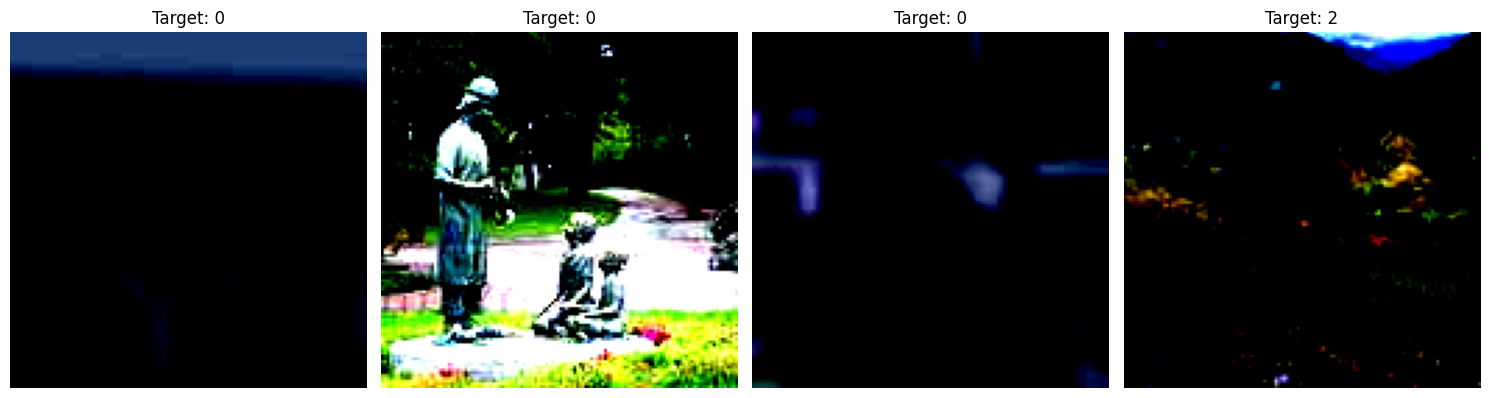

In [43]:
def show_sanity_batch(train_loader, class_labels=None):
    for batch in train_loader:
        targets, features, images = batch

        print("Targets shape:", targets.shape)
        print("Features shape:", features.shape)
        print("Images shape:", images.shape)

        # Mostrar las primeras 4 imágenes del batch
        images_np = images[:4].permute(0, 2, 3, 1).numpy()  # de [B, C, H, W] a [B, H, W, C]
        targets_np = targets[:4].numpy()

        fig, axs = plt.subplots(1, 4, figsize=(15, 5))
        for i in range(4):
            img = images[i].permute(1, 2, 0).numpy()  # De (C, H, W) a (H, W, C)
            axs[i].imshow(img)
            label = targets[i].item()
            axs[i].set_title(f'Target: {class_labels[label] if class_labels else label}')
            axs[i].axis('off')
        plt.tight_layout()
        plt.show()
        break  # Solo mostramos el primer batch

# Ejemplo de uso
show_sanity_batch(train_loader, class_labels=[0, 1, 2])

# Model

In [44]:
# Importamos las librerías necesarias
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import numpy as np
from torch.utils.data import random_split



In [45]:
# construimos el modelo base usando ResNet18 que es más pequeño que VGG16
base_model = torchvision.models.resnet18(pretrained=True)
base_model.eval()  # Set to evaluation mode

# congelamos todas las capas de nuestro base_model para que no se entrenen
# queremos que nuestro feature extractor siga igual que antes => transfer learning
for param in base_model.parameters():
    param.requires_grad = False

# cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
# Reemplazamos el clasificador con uno nuevo más pequeño para 10 clases
num_features = base_model.fc.in_features
base_model.fc = torch.nn.Linear(num_features, 3) # Added our own clasifier for the 3 categories of 'engagement_score'

#setting up for training

# definimos el optimizador y la función de pérdida
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(base_model.fc.parameters(), lr=0.001)

# vemos la estructura del modelo y el número de parámetros
print(base_model)
total_params = sum(p.numel() for p in base_model.parameters())
trainable_params = sum(p.numel() for p in base_model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 103MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [46]:
import torch.optim as optim
import torch.nn as nn

from module_utils import train_epoch, eval_epoch, evaluate_model, plot_training_curves

ModuleNotFoundError: No module named 'module_utils'

In [ ]:
class ModelTest(nn.Module):
  def__intit__(self, n_features):
    super(ModelTest, self).__init__()

    self.fc1 = nn.Linear(n_features, 1)
    pass
  def forward(self, features, im):
    x = self.fc1(features)

    # TODO process images

    x = torch.cat((x, conv), dim=1)

    # classifier
    return x

In [ ]:
import torch.optim as optim

model = ModelTest(len(features))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)